In [1]:
# http://stackoverflow.com/questions/44544766/ddg#44547144
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/ubuntu/.local/share/virtualenvs/DRIVENDATA_SUBMISSIONS/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/.local/share/virtualenvs/DRIVENDATA_SUBMISSIONS/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5441526008757758745
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12645229719139855654
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
from matplotlib import pyplot as plt
import keras

Using TensorFlow backend.


In [3]:
def pd_read_csv(fn:str):
    x = pd.read_csv(fn, na_values=['NO_LABEL', '(blank)'])
    assert not x['Unnamed: 0'].duplicated().any()
    x = x.set_index("Unnamed: 0")
    return x

## Peek at train

In [4]:
train = pd_read_csv('data_in/TrainingData.csv')
train.shape

(400277, 25)

In [5]:
train.columns

Index(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status',
       'Object_Description', 'Text_2', 'SubFund_Description',
       'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description',
       'Location_Description', 'FTE', 'Function_Description',
       'Facility_or_Department', 'Position_Extra', 'Total',
       'Program_Description', 'Fund_Description', 'Text_1'],
      dtype='object')

## Peek at test

In [6]:
test = pd_read_csv('data_in/TestData.csv')
test.shape

/home/ubuntu/.local/share/virtualenvs/DRIVENDATA_SUBMISSIONS/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(50064, 16)

In [7]:
test.columns

Index(['Object_Description', 'Program_Description', 'SubFund_Description',
       'Job_Title_Description', 'Facility_or_Department',
       'Sub_Object_Description', 'Location_Description', 'FTE',
       'Function_Description', 'Position_Extra', 'Text_4', 'Total', 'Text_2',
       'Text_3', 'Fund_Description', 'Text_1'],
      dtype='object')

## Diff columns

In [8]:
#train.loc[134338]
# pd.isnull(train['Function']).any()
# pd.isnull(test['Function']).any()
set(train.columns) - set(test.columns), set(test.columns) - set(train.columns)

({'Function',
  'Object_Type',
  'Operating_Status',
  'Position_Type',
  'Pre_K',
  'Reporting',
  'Sharing',
  'Student_Type',
  'Use'},
 set())

## Read labels

In [9]:
import yaml
labels = yaml.load(open("labels.yml",'r'))

In [10]:
# Function': ['Aides Compensation
prediction_names = []
for k,v1 in labels.items():
    for v2 in v1:
        prediction_names.append("%s__%s"%(k,v2))
        
        
assert 'Function__Aides Compensation' in prediction_names
prediction_names[:5]

['Function__Aides Compensation',
 'Function__Career & Academic Counseling',
 'Function__Communications',
 'Function__Curriculum Development',
 'Function__Data Processing & Information Services']

## Calculate counts

In [11]:
features = list(set(train.columns).intersection(set(test.columns)) - set(['FTE','Total']))
features.sort()
features

['Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4']

In [12]:
train[features].loc[134338].fillna('')

Facility_or_Department                       
Function_Description                         
Fund_Description                 General Fund
Job_Title_Description     Teacher-Elementary 
Location_Description                         
Object_Description                           
Position_Extra                  KINDERGARTEN 
Program_Description              KINDERGARTEN
SubFund_Description                          
Sub_Object_Description                       
Text_1                                       
Text_2                                       
Text_3                                       
Text_4                                       
Name: 134338, dtype: object

In [13]:
train['joined'] = train[features].fillna('').apply(lambda x: "~".join([y.replace(' ','').replace('"','') for y in x]), axis=1)

In [14]:
stats = train['joined'].value_counts()

In [15]:
stats.sort_values(ascending=False).head(n=15).reset_index()

,index,joined
0,"~NON-PROJECT~~Teacher,Elementary~~CONTRABENEFI...",4130
1,"~UNALLOCBUDGETS/SCHOOLS~~Teacher,ShortTermSub~...",3578
2,~~GeneralPurposeSchool~~~PersonalServices-Subs...,3269
3,~INSTRUCTION~GeneralFund~~~SUPPLIES~~PRIMARYGR...,3140
4,"~UNALLOCBUDGETS/SCHOOLS~~Teacher,ShortTermSub~...",2951
5,~BASIC(FEFPK-12)~GENERALFUND~SUBTEACHERALL~Sch...,2549
6,"~NON-PROJECT~~Teacher,ShortTermSub~~SALARIESOF...",2374
7,"~NON-PROJECT~~Teacher,ShortTermSub~~EMPLOYEEBE...",2270
8,"~EMPLOYEERETIREMENT~~Teacher,Elementary~~RETIR...",2032
9,~~~~~~~~~~~~~,1874


In [16]:
stats = stats.sort_index()
stats.head()

(YearEndAllocationTo~GeneralAdministration~GeneralOperatingFund~ATTORNEYS,LEGALDEPARTMENT~LegalDepartment-TaxCollectionDivision~EmployeeAllowances~ACCOUNTANT~Undistributed~Operations~TravelAllowances~TRAVEL~~~                                                                         1
(YearEndAllocationTo~GeneralAdministration~GeneralOperatingFund~ATTORNEYS,LEGALDEPARTMENT~LegalDepartment-TaxCollectionDivision~EmployeeAllowances~DIRECTOR~Undistributed~Operations~TravelAllowances~TRAVEL~~~                                                                           3
(YearEndAllocationTo~GeneralAdministration~GeneralOperatingFund~ATTORNEYS,LEGALDEPARTMENT~LegalDepartment-TaxCollectionDivision~SalariesAndWagesForTeachersAndOtherProfessi~ACCOUNTANT~Undistributed~Operations~SalariesAndWagesForTeachersAndOtherProfessi~REGULARPAY~~~                 1
(YearEndAllocationTo~GeneralAdministration~GeneralOperatingFund~ATTORNEYS,LEGALDEPARTMENT~LegalDepartment-TaxCollectionDivision~SalariesAndWagesForT

In [17]:
k1=stats.index[10]
stats.index.get_loc(k1)

10

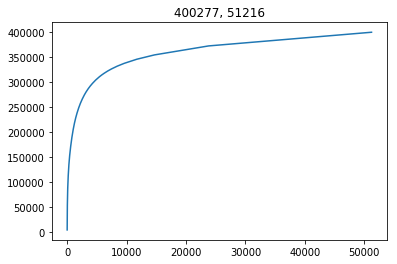

In [18]:
# plt.bar(x=range(stats.shape[0]), height=stats.values)
# n_pts = 500000
# plt.bar(x=range(n_pts), height=stats.iloc[:n_pts])
plt.plot(stats.sort_values(ascending=False).values.cumsum())
plt.title("%s, %s"%(stats.values.sum(), stats.shape[0]))
plt.show()

In [19]:
k1 = stats.sort_values(ascending=False).reset_index().loc[0]['index']

In [20]:
train[train['joined']==k1].shape, train.shape[0]

((4130, 26), 400277)

In [21]:
train[train['joined']==k1]['Function'].value_counts().reset_index()

,index,Function
0,Teacher Compensation,3915
1,Extended Time & Tutoring,215


In [22]:
import os

# The 1st version turned out to have indeces not in stats.index .. weird
# prob_fn = 'data_out/t1_probabilities_function.pkl'

# Fixing the above in the 2nd version
# prob_fn = 'data_out/t1_probabilities_function_v2.pkl'

# Set ".sort()" on features so that they're replicable
# prob_fn = 'data_out/t1_probabilities_function_v3.pkl'

# Calculate for all targets, not only Functions
prob_fn = 'data_out/t1_probabilities_function_v4.pkl'

os.path.exists(prob_fn)

False

In [46]:
if os.path.exists(prob_fn):
    probabilities = pd.read_pickle(prob_fn)
else:
    panel = {}
    for k2 in labels.keys():
        panel[k2] = pd.DataFrame(
            np.zeros(shape=(len(labels[k2]), stats.shape[0])),
            columns=stats.index,
            index=labels[k2]
        )
        #probabilities.head(n=2)

        # k1 = stats.index[0]
        # probabilities[k1].update(train[train['joined']==k1]['Function'].value_counts())
        # probabilities[k1]

        n = len(stats.index)
        for i,k1 in enumerate(stats.head().index):
            if i % 1000 == 0: print("%s .. %s: %s / %s"%(time.ctime(), k2, i, n))
            panel[k2][k1].update(train[train['joined']==k1][k2].value_counts())

    #probabilities = pd.Panel(probabilities)
    
    # save
    #probabilities.to_pickle(prob_fn)

Wed Apr  4 05:38:28 2018 .. Function: 0 / 51216
Wed Apr  4 05:38:28 2018 .. Object_Type: 0 / 51216
Wed Apr  4 05:38:28 2018 .. Operating_Status: 0 / 51216
Wed Apr  4 05:38:29 2018 .. Position_Type: 0 / 51216
Wed Apr  4 05:38:29 2018 .. Pre_K: 0 / 51216
Wed Apr  4 05:38:29 2018 .. Reporting: 0 / 51216
Wed Apr  4 05:38:29 2018 .. Sharing: 0 / 51216
Wed Apr  4 05:38:29 2018 .. Student_Type: 0 / 51216
Wed Apr  4 05:38:30 2018 .. Use: 0 / 51216


In [49]:
for dependent, probabilities in panel.items():
    print(dependent, probabilities.shape)

Function (37, 51216)
Object_Type (11, 51216)
Operating_Status (3, 51216)
Position_Type (25, 51216)
Pre_K (3, 51216)
Reporting (3, 51216)
Sharing (5, 51216)
Student_Type (9, 51216)
Use (8, 51216)


In [45]:
# since NO_LABEL is replaced with NaN, need this
for dependent, probabilities in panel.items():
    panel[dependent].loc['NO_LABEL',panel[dependent].sum(axis=0)==0]=1

In [51]:
for dependent, probabilities in panel.items():
    print(dependent, probabilities.shape, probabilities[pd.isnull(probabilities).all(axis=1)].shape, probabilities.loc[:,probabilities.sum(axis=0)==0].shape)

Function (37, 51216) (0, 51216) (37, 51211)
Object_Type (11, 51216) (0, 51216) (11, 51211)
Operating_Status (3, 51216) (0, 51216) (3, 51211)
Position_Type (25, 51216) (0, 51216) (25, 51211)
Pre_K (3, 51216) (0, 51216) (3, 51211)
Reporting (3, 51216) (0, 51216) (3, 51211)
Sharing (5, 51216) (0, 51216) (5, 51211)
Student_Type (9, 51216) (0, 51216) (9, 51211)
Use (8, 51216) (0, 51216) (8, 51211)


In [52]:
for dependent, probabilities in panel.items():
    # k1 = stats.index[1]
    # probabilities[k1], (probabilities / probabilities.sum(axis=0))[k1]
    probabilities = probabilities / probabilities.sum(axis=0)

    probabilities = probabilities.transpose()

    probabilities = probabilities.sort_index()
    
    panel[dependent] = probabilities

    print(dependent, probabilities.shape)

Function (51216, 37)
Object_Type (51216, 11)
Operating_Status (51216, 3)
Position_Type (51216, 25)
Pre_K (51216, 3)
Reporting (51216, 3)
Sharing (51216, 5)
Student_Type (51216, 9)
Use (51216, 8)


In [54]:
for dependent, probabilities in panel.items():
    print(dependent, probabilities.shape, probabilities[pd.isnull(probabilities).all(axis=1)].shape, probabilities[probabilities.sum(axis=1)==0].shape)

Function (51216, 37) (51211, 37) (51211, 37)
Object_Type (51216, 11) (51211, 11) (51211, 11)
Operating_Status (51216, 3) (51211, 3) (51211, 3)
Position_Type (51216, 25) (51211, 25) (51211, 25)
Pre_K (51216, 3) (51211, 3) (51211, 3)
Reporting (51216, 3) (51211, 3) (51211, 3)
Sharing (51216, 5) (51211, 5) (51211, 5)
Student_Type (51216, 9) (51211, 9) (51211, 9)
Use (51216, 8) (51211, 8) (51211, 8)


In [ ]:
for dependent, probabilities in panel.items():
    assert set(stats.index) == set(probabilities.index)
    assert len(set(stats.index) - set(probabilities.index)) == 0
    assert len(set(probabilities.index) - set(stats.index)) == 0

## Bring back original set of columns
These are the fields that got joined with ~

In [ ]:
vocabulary = train[~train.duplicated(['joined'])][features+['joined']].set_index('joined').sort_index()

In [ ]:
vocabulary.head(n=2)

In [ ]:
for dependent, probabilities in panel.items():
    assert set(probabilities.index) == set(vocabulary.index)
    assert len(set(probabilities.index) - set(vocabulary.index)) == 0
    assert len(set(vocabulary.index) - set(probabilities.index)) == 0

In [ ]:
# append "set_index" as recommended in pandas github issue 7632
# https://github.com/pandas-dev/pandas/issues/7632#issuecomment-316806258
# prob2 = probabilities.merge(vocabulary, left_index=True, right_on='joined', how='left').set_index('joined')

prob2 = {}
for dependent, probabilities in panel.items():
    prob2[dependent] = probabilities.merge(vocabulary, left_index=True, right_index=True, how='left') # .set_index('joined')
    print(dependent, probabilities.shape, prob2[dependent].shape) # , prob2.head(n=2), prob2.head(n=2).index # , train.loc[70455]

In [ ]:
for dependent in panel:
    prob2[dependent][features].sort_index().head(n=2)

In [ ]:
print(time.ctime())
prob3={}
for dependent in panel:
    prob3[dependent] = prob2[dependent][features].apply(lambda x: pd.factorize(x)[0], axis=0)
    prob3[dependent] = prob3[dependent] + 1 # +1 for the -1 (keras Embedding supports [0,N) )
    
print(time.ctime())

In [ ]:
prob3.max().max(), prob3.min().min()

In [ ]:
prob3.shape, probabilities.shape

In [ ]:
prob3.max(axis=0)

## split hold-out

In [ ]:
x = prob3
y = probabilities # .fillna(0)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# make array of features
x_train = [x_train[f].values for f in vocab_size.index]
x_test  = [x_test [f].values for f in vocab_size.index]

## keras embedding + Dense/LSTM

In [ ]:
vocab_size = prob3.max(axis=0) + 1 # +1 for the 0

In [ ]:
#vocab_size.index, prob3.columns
vocab_size

In [ ]:
probabilities.shape[1]

In [ ]:
from keras.layers import Embedding, Dense, Flatten, LSTM, Input, Concatenate, Add, Lambda
from keras.models import Sequential, Model
from keras import backend as K

# vocab_size = stats.shape[0]

# inputs = [Input(shape=(prob3.shape[1],)) for f in vocab_size.index]
inputs = {f: Input(shape=(1,), name=f) for f in vocab_size.index}

# embeddings = [Embedding(vocab_size[f], embedding_dim, input_length=prob3.shape[1]) for f in vocab_size.index]

if True:
    embedding_dim = 3 # 12 # 2 # 64 # FIXME
    embeddings = [Embedding(vocab_size[f], embedding_dim, input_length=1)(inputs[f]) for f in vocab_size.index]
else:
    embeddings = [Embedding(vocab_size[f], max(3, vocab_size[f]//15//10), input_length=1)(inputs[f]) for f in vocab_size.index]

# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, input_length, embedding_dim), where None is the batch dimension.

x1 = Concatenate()(embeddings)

x1 = Flatten()(x1)
#x1 = Dense( 500, activation='relu')(x1)
# x1 = Dense(  50, activation='relu')(x1)
x1 = Dense(  50, activation='relu')(x1)
x1 = Dense(  50, activation='relu')(x1)
o1 = Dense(probabilities.shape[1], activation = 'softmax', name='predicted')(x1)
#o2 = Lambda(lambda x: K.sum(x, axis=1, keepdims=True), name='sum')(o1)
#o3 = Lambda(lambda x: K.argmax(x, axis=-1), output_shape=(1,), dtype='int64', name='argmax')(o1)
#outputs = [o1, o2, o3]
outputs = [o1]

inputs = [inputs[f] for f in vocab_size.index]
model = Model(inputs=inputs, outputs=outputs)
model.summary()

In [ ]:
def multi_multiclass_logloss(y_true, y_pred):
    # when statring to use Function and others, use this
    # return K.mean(-1*K.mean(K.batch_dot(y_true, K.log(y_pred)), axis=-1), axis=-1)
    # _epsilon = K.epsilon() * K.ones_like(y_true)
    y_pred2 = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    output = -1*K.mean(K.batch_dot(K.transpose(y_true), K.log(y_pred2), axes=[0,1]), axis=-1)
    return output

# model.compile('rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.compile('rmsprop', loss=multi_multiclass_logloss, metrics=['acc'])

In [ ]:
# test K.batch_dot
# Need to specify axes due to issue
# https://github.com/keras-team/keras/issues/9847
x_batch = K.ones(shape=(32, 37))
y_batch = K.ones(shape=(32, 37))
# xy_batch_dot = K.batch_dot(K.transpose(x_batch), y_batch, axes=[0, 1])
xy_batch_dot = multi_multiclass_logloss(x_batch, y_batch)
K.int_shape(xy_batch_dot), K.eval(xy_batch_dot)

In [ ]:
# from keras.utils import to_categorical
# y_binary = to_categorical(np.argmax(y_train.values, axis=1))
# y_binary = np.argmax(y_train.values, axis=1).squeeze()

model.fit(
    # pd.get_dummies(train3['x'].values),
    # # train2[list(set(train2.columns) - set(['joined']))],
    # train3['y'].values,
    x_train,
    [
        y_train,
        #np.ones(shape=(y_train.shape[0],1)),
        #y_binary,
    ],
    epochs=100,
    verbose=2,
    validation_split = 0.2,
    shuffle=False
)

In [ ]:
model.evaluate(
    x_test,
    [
        y_test,
        # np.ones(shape=(y_test.shape[0],1))
    ]
)

## argmax accuracy

In [ ]:
my_score = np.zeros(y_test.shape[0], dtype='uint8')
# y_pred, sum_pred = model.predict([x_test[f].values for f in vocab_size.index])
y_pred = model.predict([x_test[f].values for f in vocab_size.index])
for i in range(y_test.shape[0]):
    v1 = y_test.iloc[i].idxmax()
    v2 = probabilities.columns[np.argmax(y_pred[i])]
    my_score[i] = 1 if (v1 == v2) else 0

In [ ]:
sum(my_score), my_score.shape[0], sum(my_score)*100 // my_score.shape[0]

## Spatial comparison

In [ ]:
for i in range(probabilities.shape[1]):
    n_show = 1000
    y_pred = model.predict([x_test[f].values[:n_show] for f in vocab_size.index])

    plt.figure(figsize=(20,3))
    plt.plot(y_pred[:n_show,i], label='pred')
    #plt.plot(sum_pred, label='sum_pred', alpha=0.2)
    plt.plot(y_test.iloc[:n_show,i].values, '.', label='actual')
    plt.legend(loc='best')
    plt.title(y_test.columns[i])
    
    axes = plt.gca()
    axes.set_ylim([-.1,1.1])
    plt.show()

In [ ]:
y_test.iloc[0].sum(), y_pred[0].sum() # , y_pred[0]

## temporal comparison

In [ ]:
y_pred = model.predict([x_test[f].values for f in vocab_size.index])

for i in range(15):
    plt.figure(figsize=(10,3))
    
    plt.subplot(121)
    plt.bar(x=range(y_pred.shape[1]), height=y_test.iloc[i].values)
    plt.title('%s. prediction, argmax=%s'%(i,np.argmax(y_test.iloc[i].values)))
    
    plt.subplot(122)
    plt.bar(x=range(y_pred.shape[1]), height=y_pred[i])
    plt.title('%s. actual, argmax=%s'%(i,np.argmax(y_pred[i])))
    
    # plt.title(y_test.index[i])
    
    plt.show()

In [ ]:
i=6
y_test.iloc[i].values

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=None, random_state=0, verbose=2, n_jobs=-1)


regr.fit(x_train, y_train)

In [ ]:
print(prob3.columns, regr.feature_importances_)

In [ ]:
print(regr.score(x_test, y_test))

In [ ]:
y_pred_rf = regr.predict(x_test[:3]) # .round(1)

In [ ]:
y_pred_rf.sum(axis=1), y_pred_rf[0], y_test[:3].values